In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# import the sd-data overlay module
import os
import sys
module_path = os.path.abspath(os.path.join('../py/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import sd_scan_muh

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Some constants
eventDate = datetime.datetime(2011,7,5)
timeStart = datetime.datetime(2011,7,5,3,0)
timeEnd = datetime.datetime(2011,7,5,7,0)
sapsTime = datetime.datetime(2011,7,5,5,0)
tecScale = [ 0, 10 ]
trghLatRange = [ 50, 75 ]
tecMlon = -70 + 360
nrstMlonCutoff = 2

In [3]:
# read TEC data from the feather file
tecDF = feather.read_dataframe('../data/tec-mf-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
tecDF.head()

dateStr  timeStr  Mlat  Mlon  med_tec  dlat  dlon                date  \
0  20110705      300  11.0   0.0      5.4   1.0   2.0 2011-07-05 03:00:00   
1  20110705      300  11.0   2.0     10.2   1.0   2.0 2011-07-05 03:00:00   
2  20110705      300  11.0   4.0      8.9   1.0   2.0 2011-07-05 03:00:00   
3  20110705      300  11.0   6.0      7.5   1.0   2.0 2011-07-05 03:00:00   
4  20110705      300  11.0   8.0      7.4   1.0   2.0 2011-07-05 03:00:00   

         MLT  
0  22.205744  
1  22.339078  
2  22.472411  
3  22.605744  
4  22.739078

In [4]:
# Get the min loc of trough at diff MLONs
trghLocsDF = tecDF[ (tecDF["med_tec"] <= 20.) &\
                  (tecDF["Mlat"] >= trghLatRange[0]) &\
                  (tecDF["Mlat"] <= trghLatRange[1]) ]
trghLocsDF["time"] = [ date2num(x) for x in trghLocsDF["date"] ]
trghMinDF = trghLocsDF[ ["time", "Mlon", "med_tec"]\
                 ].groupby( [ "time", "Mlon" ]\
                ).min().reset_index()
trghMinDF["Mlon2"] = [x-360 if x>180 else x for x in trghMinDF["Mlon"] ]
trghMinDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


time  Mlon  med_tec  Mlon2
0  734323.125   0.0      4.6    0.0
1  734323.125   2.0      4.2    2.0
2  734323.125   4.0      4.2    4.0
3  734323.125   6.0      4.0    6.0
4  734323.125   8.0      4.9    8.0

In [5]:
trghMlatDF = pandas.merge( trghLocsDF[ ["time", "Mlon", "Mlat",\
                            "date", "med_tec"] ],\
                          trghMinDF,\
                          on=["time", "Mlon", "med_tec"] )
# drop duplicates
trghMlatDF = trghMlatDF.drop_duplicates(\
                    subset=["time", "Mlon",  "Mlon2"], keep="first")
trghMlatDF.head()

time   Mlon  Mlat                date  med_tec  Mlon2
0  734323.125  130.0  50.0 2011-07-05 03:00:00      9.6  130.0
3  734323.125  142.0  50.0 2011-07-05 03:00:00      7.9  142.0
6  734323.125  166.0  50.0 2011-07-05 03:00:00      9.8  166.0
7  734323.125  180.0  50.0 2011-07-05 03:00:00     12.0  180.0
8  734323.125  198.0  50.0 2011-07-05 03:00:00      5.8 -162.0

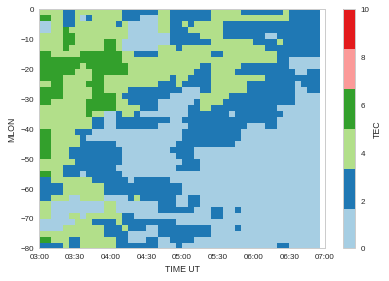

In [6]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMinDF[ ["time", "Mlon2",\
                        "med_tec"] ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
tecVals = numpy.ma.masked_where(\
                numpy.isnan(plotDF["med_tec"].values),\
                plotDF["med_tec"].values)
rtiPlot = ax.pcolormesh(timeCntr.T, mlonCntr.T , tecVals,\
                        cmap=seaMap, vmin=tecScale[0],vmax=tecScale[1])

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [ -80, 0 ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLON")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_xticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

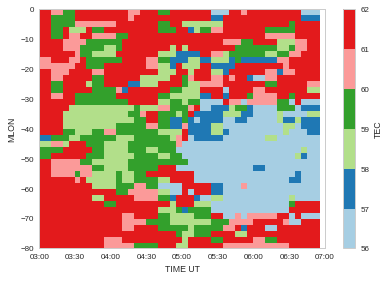

In [7]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
plotDF = trghMlatDF[ ["time", "Mlon2",\
                        "Mlat"] \
                   ].pivot( "time", "Mlon2" )

timeVals = plotDF.index.values
mlonVals = plotDF.columns.levels[1].values

timeCntr, mlonCntr  = numpy.meshgrid( timeVals, mlonVals )
# Mask the nan values! pcolormesh can't handle them well!
mlatVals = numpy.ma.masked_where(numpy.isnan(\
                plotDF["Mlat"].values), plotDF["Mlat"].values)
rtiPlot = ax.pcolormesh(timeCntr.T, mlonCntr.T , mlatVals,\
                        cmap=seaMap, vmin=56., vmax=62.)

ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [ -80, 0 ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLON")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

ax.set_xticks(xTickList)

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-lats-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


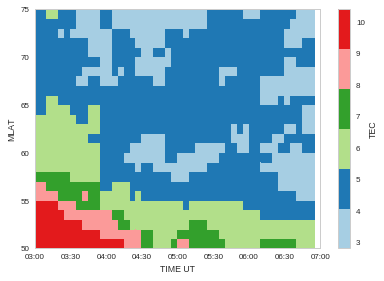

In [8]:
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
# setup the figure
fig = plt.figure()
ax = fig.add_subplot(111)
seaMap = ListedColormap(sns.color_palette("Paired"))
# xticks
# set a few standard xticks
xTickList = []
currTime = timeStart
while currTime <= timeEnd:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=30)
    
selDF = tecDF[ ((tecDF["date"] >= timeStart) &\
                       (tecDF["date"] <= timeEnd) &\
                    (tecDF["Mlat"] <= trghLatRange[1]) &\
                       (tecDF["Mlat"] >= trghLatRange[0]) )]
selDF["time"] = [ date2num(x) for x in selDF["date"] ]
selDF = selDF[ ["Mlat", "time", "med_tec"]\
             ].groupby( ["Mlat", "time"] ).median().reset_index()

plotmedFiltTECDF = selDF[ ["Mlat", "time",\
                        "med_tec"] ].pivot( "Mlat", "time" )
mlatVals = plotmedFiltTECDF.index.values
timeVals = plotmedFiltTECDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
med_tecVals = numpy.ma.masked_where(numpy.isnan(plotmedFiltTECDF["med_tec"].values),plotmedFiltTECDF["med_tec"].values)
trghPlot = ax.pcolormesh(timeCntr, mlatCntr,med_tecVals.T,cmap=seaMap)
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME UT")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(trghPlot, orientation='vertical')
cbar.set_label("TEC")

fig.savefig("../plots/tec-long-cut-" +\
            sapsTime.strftime("%Y%m%d") +\
            ".pdf" ,bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


2011-07-05 03:32:00 2011-07-05 03:34:00
2011-07-05 03:32:00 2011-07-05 03:34:00
2011-07-05 03:32:00 2011-07-05 03:34:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:34:00 2011-07-05 03:36:00
2011-07-05 03:34:00 2011-07-05 03:36:00
2011-07-05 03:34:00 2011-07-05 03:36:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:36:00 2011-07-05 03:38:00
2011-07-05 03:36:00 2011-07-05 03:38:00
2011-07-05 03:36:00 2011-07-05 03:38:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:38:00 2011-07-05 03:40:00
2011-07-05 03:38:00 2011-07-05 03:40:00
2011-07-05 03:38:00 2011-07-05 03:40:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:40:00 2011-07-05 03:42:00
2011-07-05 03:40:00 2011-07-05 03:42:00
2011-07-05 03:40:00 2011-07-05 03:42:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:42:00 2011-07-05 03:44:00
2011-07-05 03:42:00 2011-07-05 03:44:00
2011-07-05 03:42:00 2011-07-05 03:44:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:44:00 2011-07-05 03:46:00
2011-07-05 03:44:00 2011-07-05 03:46:00
2011-07-05 03:44:00 2011-07-05 03:46:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:46:00 2011-07-05 03:48:00
2011-07-05 03:46:00 2011-07-05 03:48:00
2011-07-05 03:46:00 2011-07-05 03:48:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:48:00 2011-07-05 03:50:00
2011-07-05 03:48:00 2011-07-05 03:50:00
2011-07-05 03:48:00 2011-07-05 03:50:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:50:00 2011-07-05 03:52:00
2011-07-05 03:50:00 2011-07-05 03:52:00
2011-07-05 03:50:00 2011-07-05 03:52:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:52:00 2011-07-05 03:54:00
2011-07-05 03:52:00 2011-07-05 03:54:00
2011-07-05 03:52:00 2011-07-05 03:54:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:54:00 2011-07-05 03:56:00
2011-07-05 03:54:00 2011-07-05 03:56:00
2011-07-05 03:54:00 2011-07-05 03:56:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:56:00 2011-07-05 03:58:00
2011-07-05 03:56:00 2011-07-05 03:58:00
2011-07-05 03:56:00 2011-07-05 03:58:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 03:58:00 2011-07-05 04:00:00
2011-07-05 03:58:00 2011-07-05 04:00:00
2011-07-05 03:58:00 2011-07-05 04:00:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:00:00 2011-07-05 04:02:00
2011-07-05 04:00:00 2011-07-05 04:02:00
2011-07-05 04:00:00 2011-07-05 04:02:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:02:00 2011-07-05 04:04:00
2011-07-05 04:02:00 2011-07-05 04:04:00
2011-07-05 04:02:00 2011-07-05 04:04:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:04:00 2011-07-05 04:06:00
2011-07-05 04:04:00 2011-07-05 04:06:00
2011-07-05 04:04:00 2011-07-05 04:06:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:06:00 2011-07-05 04:08:00
2011-07-05 04:06:00 2011-07-05 04:08:00
2011-07-05 04:06:00 2011-07-05 04:08:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:08:00 2011-07-05 04:10:00
2011-07-05 04:08:00 2011-07-05 04:10:00
2011-07-05 04:08:00 2011-07-05 04:10:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:10:00 2011-07-05 04:12:00
2011-07-05 04:10:00 2011-07-05 04:12:00
2011-07-05 04:10:00 2011-07-05 04:12:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2011-07-05 04:12:00 2011-07-05 04:14:00
2011-07-05 04:12:00 2011-07-05 04:14:00
2011-07-05 04:12:00 2011-07-05 04:14:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:14:00 2011-07-05 04:16:00
2011-07-05 04:14:00 2011-07-05 04:16:00
2011-07-05 04:14:00 2011-07-05 04:16:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:16:00 2011-07-05 04:18:00
2011-07-05 04:16:00 2011-07-05 04:18:00
2011-07-05 04:16:00 2011-07-05 04:18:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:18:00 2011-07-05 04:20:00
2011-07-05 04:18:00 2011-07-05 04:20:00
2011-07-05 04:18:00 2011-07-05 04:20:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:20:00 2011-07-05 04:22:00
2011-07-05 04:20:00 2011-07-05 04:22:00
2011-07-05 04:20:00 2011-07-05 04:22:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:22:00 2011-07-05 04:24:00
2011-07-05 04:22:00 2011-07-05 04:24:00
2011-07-05 04:22:00 2011-07-05 04:24:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:24:00 2011-07-05 04:26:00
2011-07-05 04:24:00 2011-07-05 04:26:00
2011-07-05 04:24:00 2011-07-05 04:26:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:26:00 2011-07-05 04:28:00
2011-07-05 04:26:00 2011-07-05 04:28:00
2011-07-05 04:26:00 2011-07-05 04:28:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:28:00 2011-07-05 04:30:00
2011-07-05 04:28:00 2011-07-05 04:30:00
2011-07-05 04:28:00 2011-07-05 04:30:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:30:00 2011-07-05 04:32:00
2011-07-05 04:30:00 2011-07-05 04:32:00
2011-07-05 04:30:00 2011-07-05 04:32:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


2011-07-05 04:32:00 2011-07-05 04:34:00
2011-07-05 04:32:00 2011-07-05 04:34:00
2011-07-05 04:32:00 2011-07-05 04:34:00


ERROR:root:Sorry, we could not find any data for you :(
ERROR:root:Your pointer does not point to any data


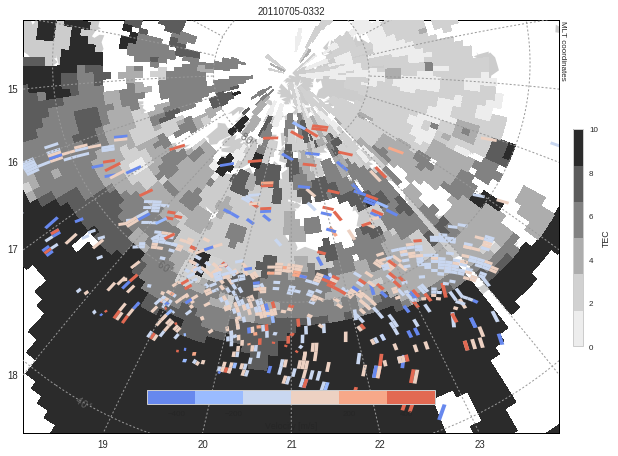

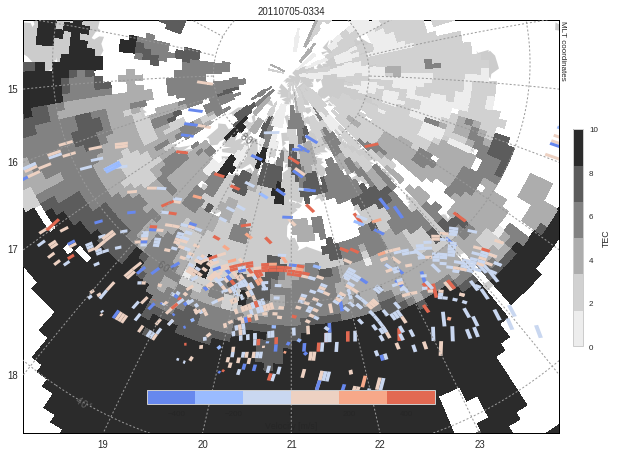

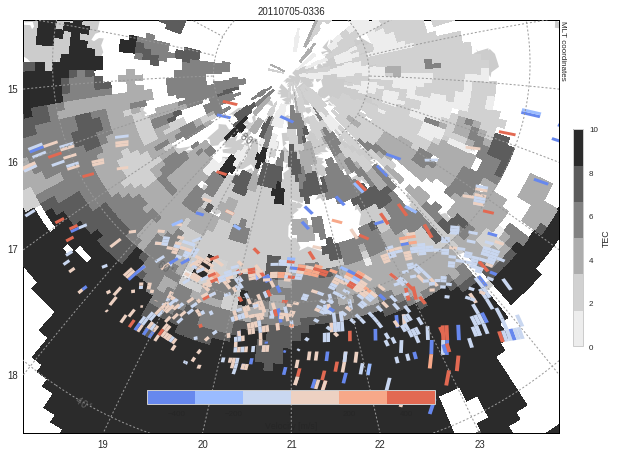

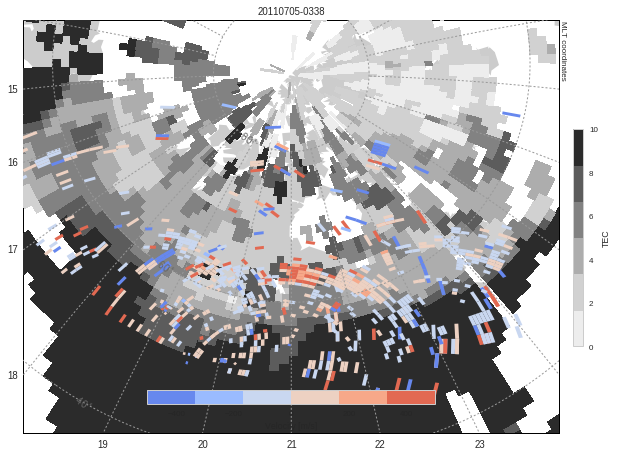

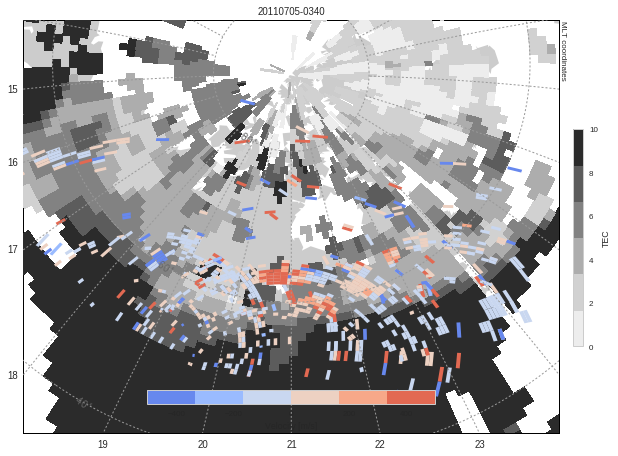

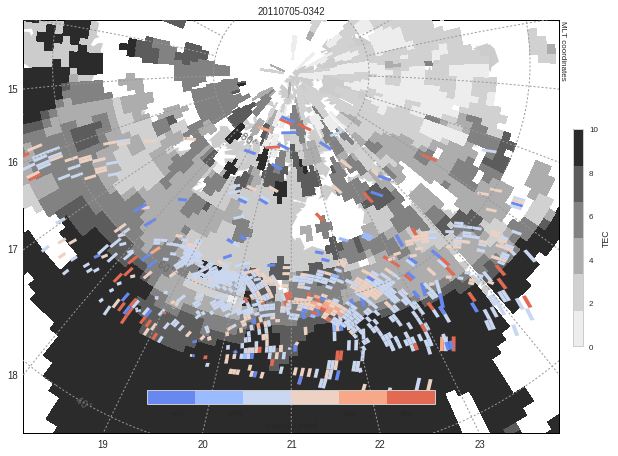

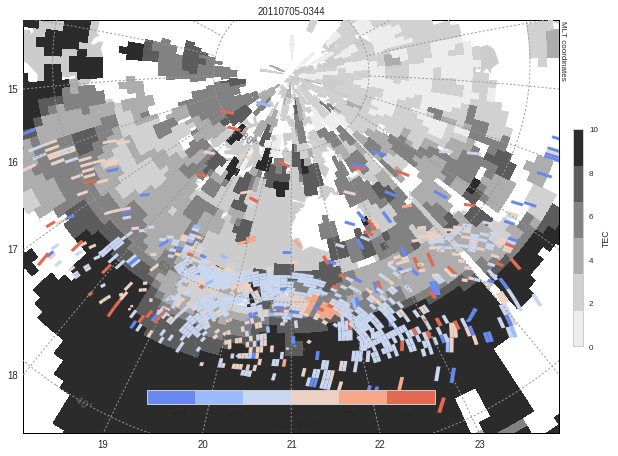

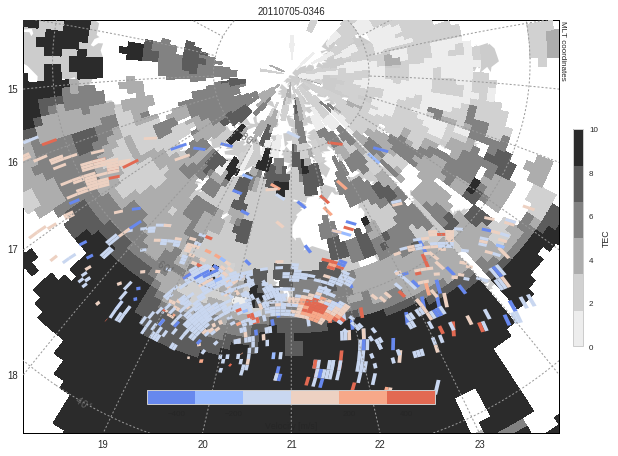

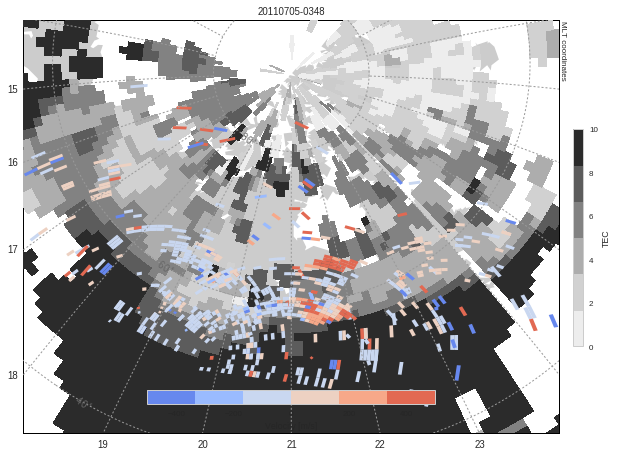

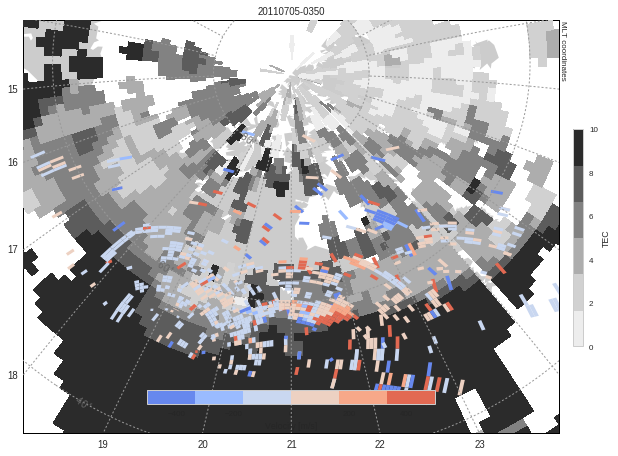

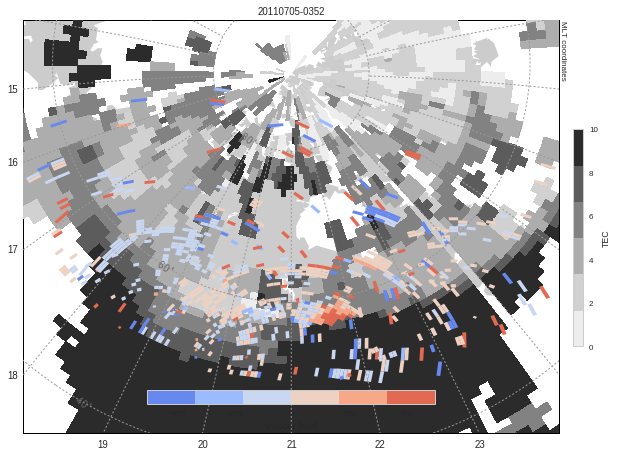

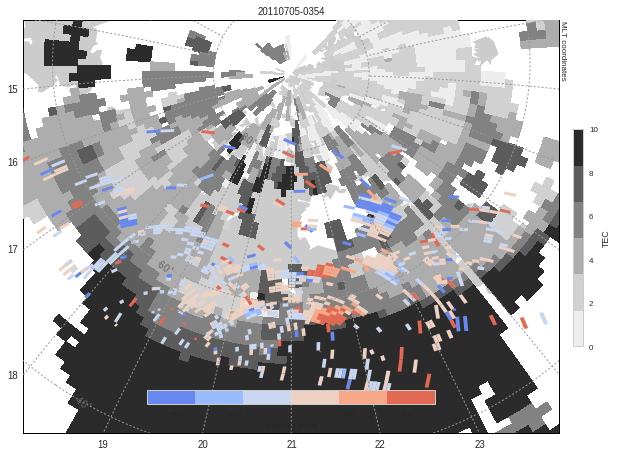

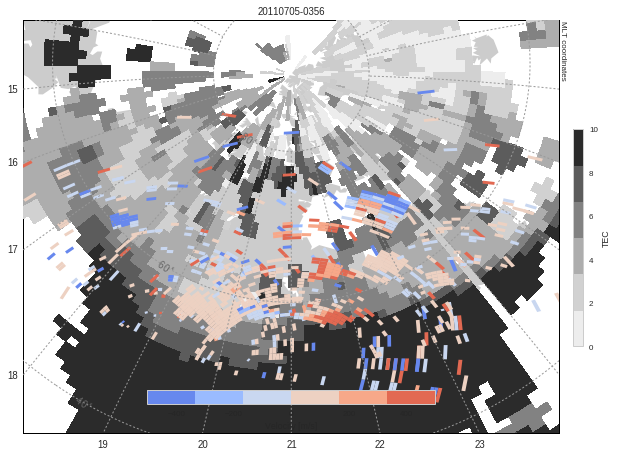

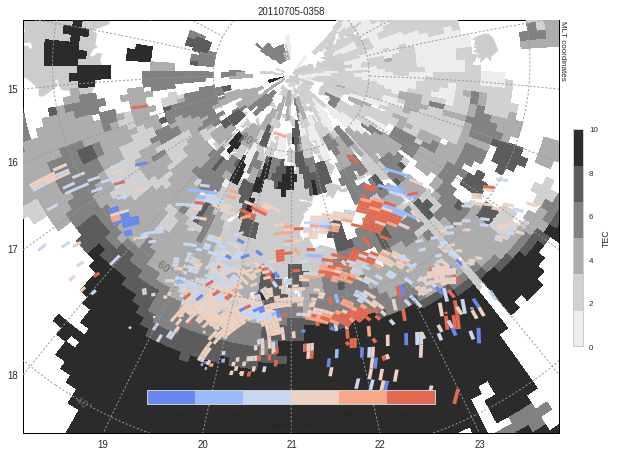

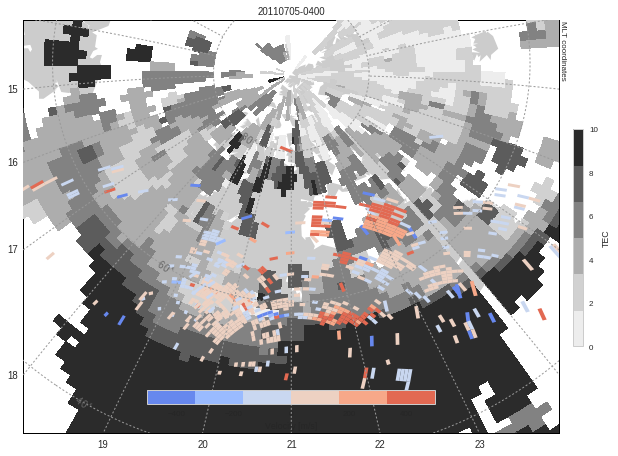

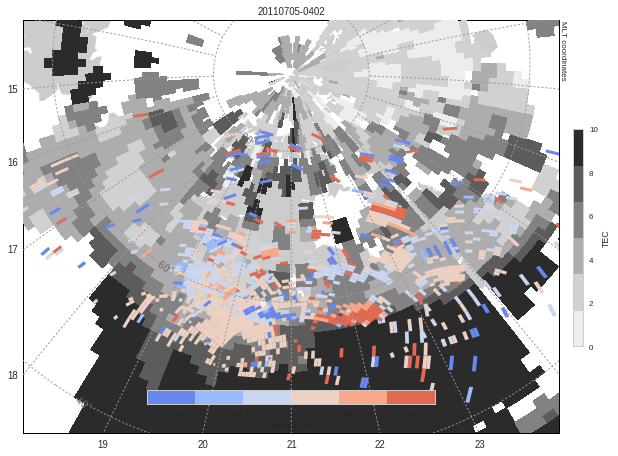

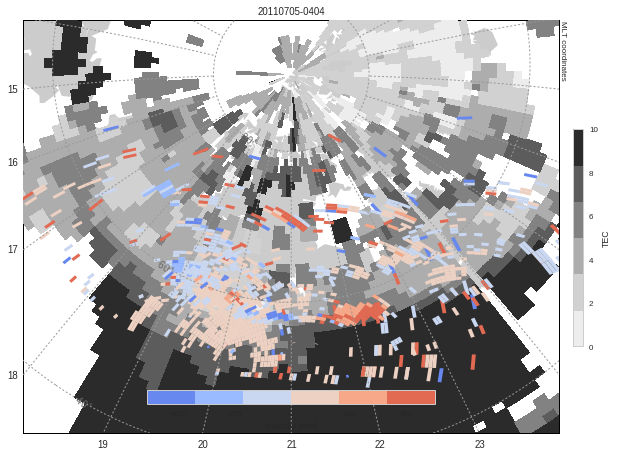

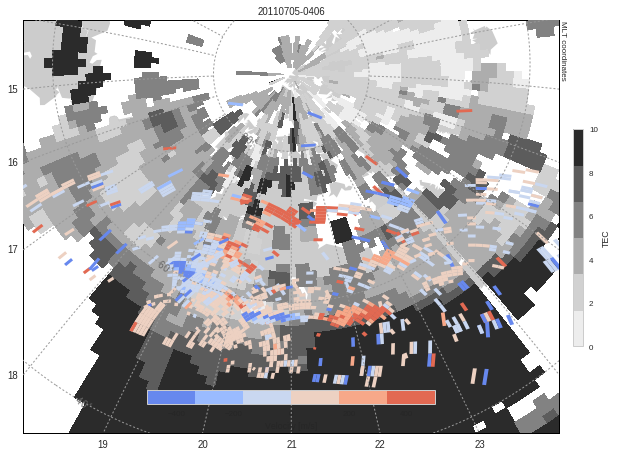

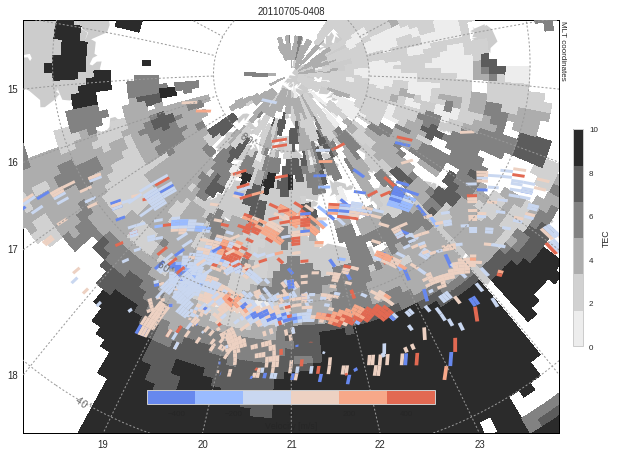

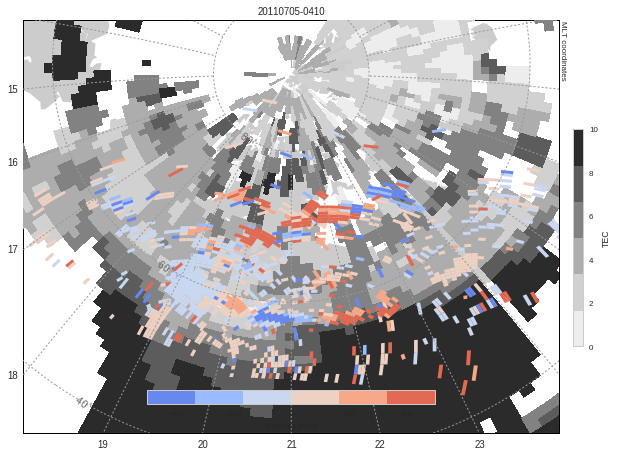

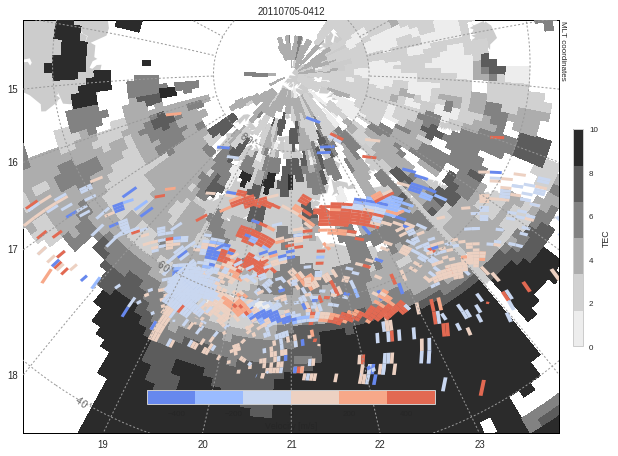

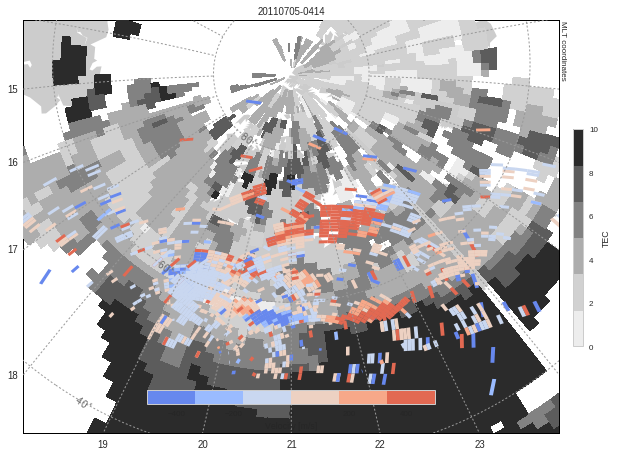

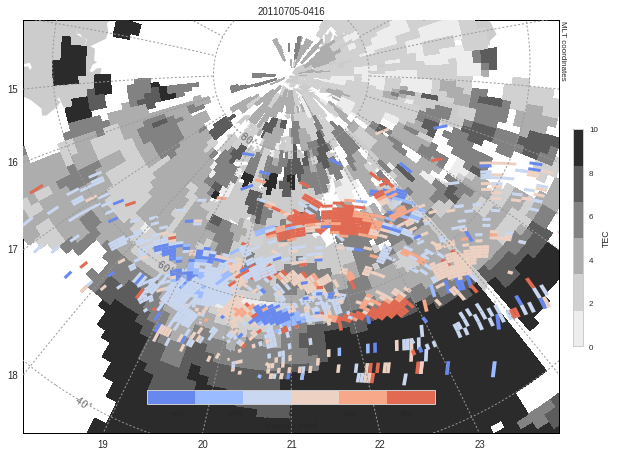

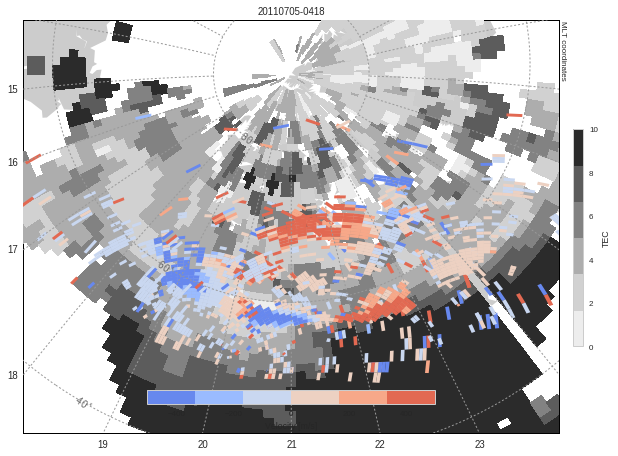

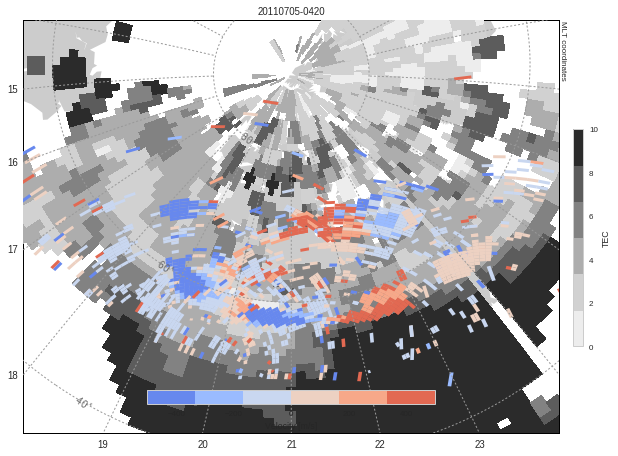

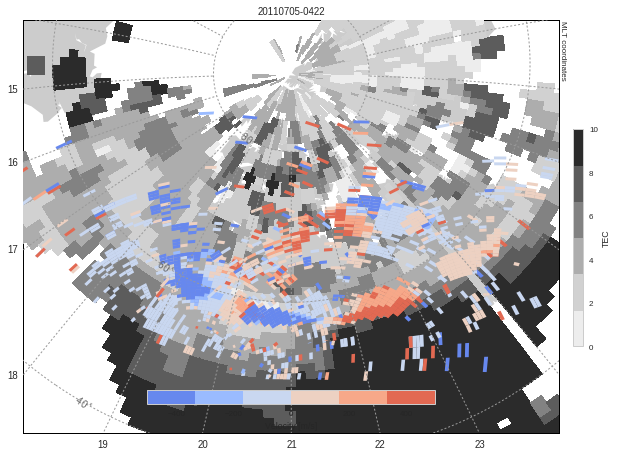

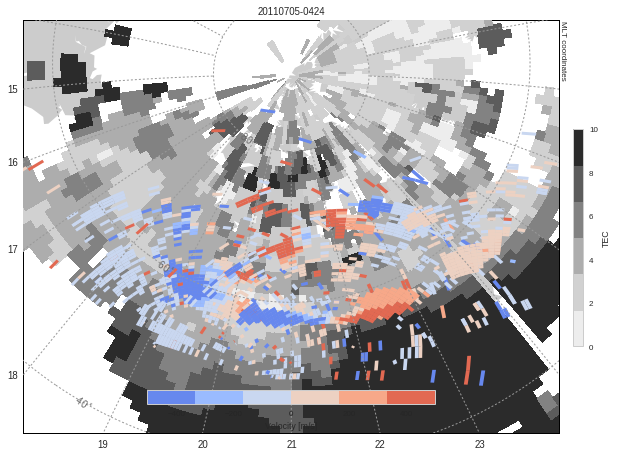

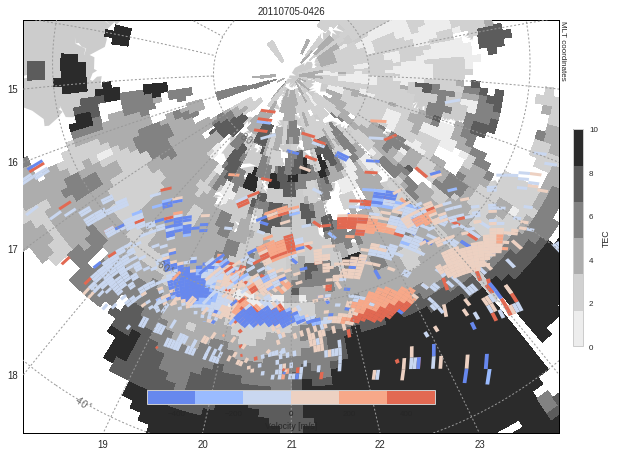

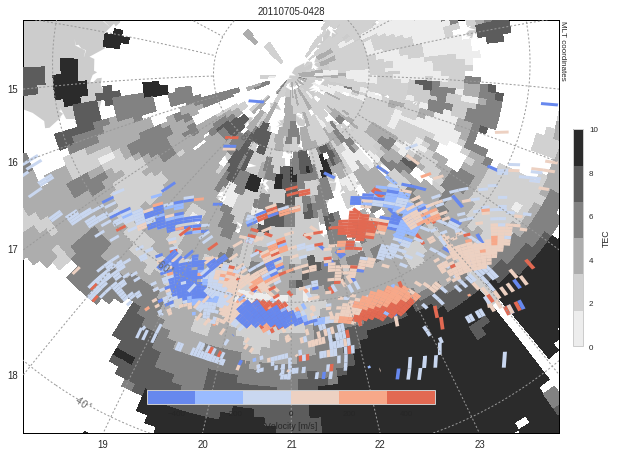

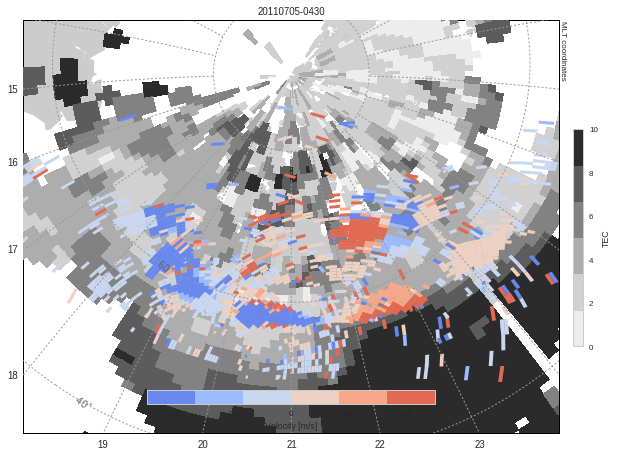

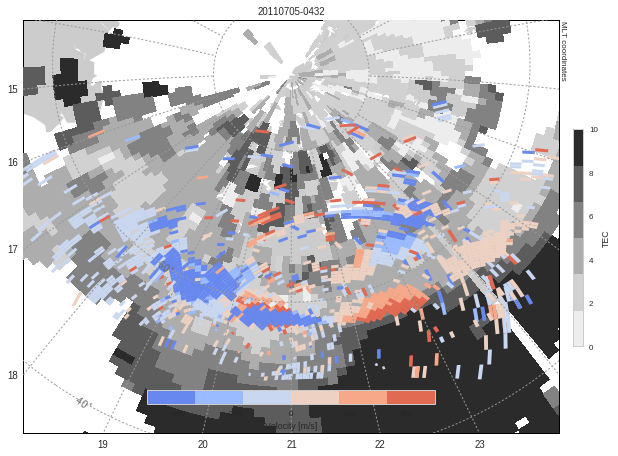

In [12]:
# Make a movie
pdf_pages = PdfPages("../plots/sd-tec-movie.pdf")
# SD plot variables
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]
coords="mlt"
movTimeStart = datetime.datetime(2011,7,5,3,30)
movTimeEnd = datetime.datetime(2011,7,5,4,30)
velScale = [ -500, 500 ]

currTime = movTimeStart
while currTime <= movTimeEnd:
    currTime += datetime.timedelta(minutes=2)
    # get TEC data
    # set colorbar
    tecSeaMap = ListedColormap(sns.color_palette("Greys"))
    velSeaMap = ListedColormap( sns.color_palette("coolwarm") )
    # Sometimes we dont have TEC data at the required time
    # get the closest times where we have TEC data
    minDT = 1e3
    closestDate = None
    for tt in tecDF["date"].unique():
        ts = (tt - numpy.datetime64('1970-01-01T00:00:00Z')) / numpy.timedelta64(1, 's')
        dt = datetime.datetime.utcfromtimestamp(ts)
        delDT = (dt-currTime).total_seconds()
        if abs(delDT) < abs(minDT):
            closestDate = tt
            minDT = delDT
    selTecDF = tecDF[ tecDF["date"] == closestDate ].reset_index(drop=True)
    f = plt.figure(figsize=(12, 8))
    ax = f.add_subplot(1,1,1)
    m1 = utils.plotUtils.mapObj( coords=coords,\
                               lat_0=70., lon_0=-45, width=66e3*120,\
                               height=111e3*55, datetime=currTime)

    
    plotTecDF = selTecDF[ ["MLT", "Mlat",\
                            "med_tec"] ].pivot( "MLT", "Mlat" )

    mltVals = plotTecDF.index.values * 15.
    mlatVals = plotTecDF.columns.levels[1].values

    mltCntr, mlatCntr  = numpy.meshgrid( mltVals, mlatVals )
    # Mask the nan values! pcolormesh can't handle them well!
    medFTecVals = numpy.ma.masked_where(\
                    numpy.isnan(plotTecDF["med_tec"].values),\
                    plotTecDF["med_tec"].values)
    tecPlot = m1.pcolormesh(mltCntr.T , mlatCntr.T, medFTecVals,\
                            cmap=tecSeaMap, vmin=tecScale[0],\
                            vmax=tecScale[1], zorder=7, latlon=True)

    cbar = plt.colorbar(tecPlot, orientation='vertical',\
                        shrink=0.5, pad=-0.01)
    cbar.set_label('TEC')
    # PLOT TEC Values

    obj = sd_scan_muh.sdvel_on_map(m1, ax, sapsRadList, currTime)
    colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
    obj.overlay_raw_data(param="velocity", gsct=1,\
                         fill=True, vel_lim=velScale,\
                         zorder=9, cmap=velSeaMap, norm=colNorm, alpha=1.)

    ax.set_title(currTime.strftime("%Y%m%d-%H%M"))
    cax = plt.colorbar(obj.losvel_mappable,ax=ax,cmap=velSeaMap,\
                 orientation='horizontal', shrink=0.5, pad=-0.1)
    cax.set_label('Velocity [m/s]')
    pdf_pages.savefig(f)
pdf_pages.close()